In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.feature_selection import SelectKBest

from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder

from sklearn.metrics import f1_score, confusion_matrix, auc, roc_curve, make_scorer, classification_report
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.dummy import DummyClassifier, DummyRegressor
from lightgbm import LGBMRegressor, LGBMClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.linear_model import SGDRegressor, SGDClassifier


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as imPip

import joblib

In [2]:
data0 = pd.read_csv("data.csv")

In [3]:
X_data = data0.drop(["Unnamed: 0", "SK_ID_CURR"], axis=1)
target = X_data.pop("TARGET")

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X_data, target, test_size=0.2, random_state=85, stratify=target)

### Sampling

In [5]:
X_train_sample,_, y_train_sample, _ = train_test_split(X_train, y_train, test_size=0.5, random_state=85, stratify=y_train)

# Preprocessing

In [22]:
lgb = LGBMClassifier(random_state=85)
logistic = LogisticRegression(random_state=85, max_iter=200)
randomf = RandomForestClassifier(random_state=85)
xgb = XGBClassifier(use_label_encoder = False)
dummy = DummyClassifier()

prepocessor = make_column_transformer((StandardScaler(), make_column_selector(dtype_include=np.number)),
                                      (OneHotEncoder(handle_unknown = 'ignore'), make_column_selector(dtype_exclude=np.number)))

classifiers = { 'Logistic Regression': logistic,
                'Random Forest': randomf,
                'Xgboost': xgb,
                'LGBM': lgb,
                'Dummy' : dummy
              }

In [11]:
def my_pipeline(classifier):
    
    my_pip = imPip([
    ("prepocessor", prepocessor),
    ("kbst", SelectKBest()),
    ("smote", SMOTE()),
    ("classifier", classifier)])
    
    return my_pip

In [13]:
def plot_roc_curve(classifiers, X, y, n_splits=5, pip=True):

    kf = KFold(n_splits=n_splits, random_state=85, shuffle=True)
    plt.figure(figsize=(15,12))
    for name_clf, clf in classifiers.items():
        print(name_clf)
        tprs = []
        aucs = []
        mean_fpr = np.linspace(0, 1, 50)
        for i, (train, test) in enumerate(kf.split(X, y)):

            if pip:
                model = my_pipeline(clf)
            else:
                model = clf
            
            model.fit(X.iloc[train, :], y.iloc[train])
            

            y_pred_grd = model.predict_proba(X.iloc[test, :])[:, 1]
            fpr, tpr, _ = roc_curve(y.iloc[test], y_pred_grd)

            interp_tpr = np.interp(mean_fpr, fpr, tpr)
            interp_tpr[0] = 0.0
            tprs.append(interp_tpr)
            auc_ = auc(fpr, tpr)

            aucs.append(auc_)

        mean_tpr = np.mean(tprs, axis=0)
        mean_tpr[-1] = 1.0
        mean_auc = round(auc(mean_fpr, mean_tpr),2)
        plt.plot(mean_fpr, mean_tpr,
            label=name_clf + f'(AUC = {mean_auc})',
            lw=2,
            alpha=.8)

    plt.plot([0, 1], [0, 1])
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('Taux faux positif')
    plt.ylabel('Taux vrai positif')
    plt.title('Courbe ROC')
    plt.legend(loc="lower right")
    plt.show()

Logistic Regression
Random Forest
Xgboost
[16:37:42] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:37:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:07] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:38:20] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_

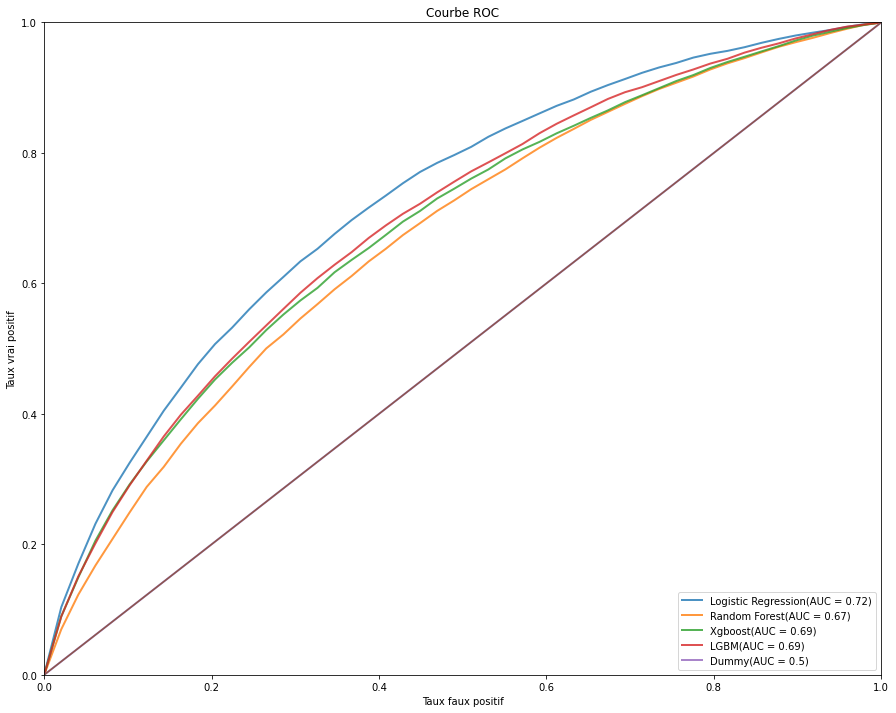

CPU times: user 32min 13s, sys: 8.46 s, total: 32min 21s
Wall time: 30min 7s


In [14]:
%%time
plot_roc_curve(classifiers, X_train_sample, y_train_sample)

## Fonction metric

In [15]:
def my_metric(y_true, y_pred, w_fn=-10, w_fp=-1, w_tp=5, w_tn=1): 
    
    matrix_conf = confusion_matrix(y_true, y_pred)
    
    # Nombre de True Negatifs
    tn = matrix_conf[0, 0]
    # Nombre de Faux Négatifs
    fn = matrix_conf[1, 0]
    # Nombre de Faux Positifs
    fp = matrix_conf[0, 1]
    # Nombre de True Positifs
    tp = matrix_conf[1, 1]
    
    # Gain 
    earn = tp*w_tp + tn*w_tn + fp*w_fp + fn*w_fn
    
    # Gain maximum
    max_earn = (fp + tn)*w_tn + (fn + tp)*w_tp
    
    # Gain minimum
    min_earn = (fp + tn)*w_fp + (fn + tp)*w_fn
    
    # Gain normalisé entre 0 et 1
    earn_norm = (earn - min_earn)/(max_earn - min_earn)
    
    return earn_norm

In [25]:
def func_build_params(param):
    new_param = {
        'kbst__k': range(5,110,10),
        'smote__k_neighbors': range(5,40,5),
        'smote__sampling_strategy':  np.arange(0.2, 1, 0.1)
    }
    for p , v in param.items():
        new_param[f"classifier__{p}"] =  v
    return new_param

In [23]:
params = {
    'Logistic_Regression' : {"C" : np.logspace(-4,5,5)
                            },
    
    "Random_Forest" : {'n_estimators': [10, 20, 50],
                       'max_depth': [10, 20, 50, None]
                      },
    
    "Xgboost" : {"n_estimators":[5,10,30,60],
                "learning_rate" : [0.001,0.01,0.1,1,5]
                },
    
    "LGBM" : {"learning_rate" : [0.001,0.01,0.1,1,5],
              "n_estimators": [10,20,50]
             }
         }

In [18]:
classifiers00 = { 'Logistic_Regression': logistic,
                'Random_Forest': randomf,
                'Xgboost': xgb,
                'LGBM': lgb
              }

In [35]:
classifiers01 = { 'Logistic_Regression': logistic,
                'Xgboost': xgb,
                'LGBM': lgb
              }

In [20]:
def evaluation_gridsearch_test(models, params, X, y):
    df = pd.DataFrame()
    i = 0
    
    skf = StratifiedKFold(n_splits=4)
    
    best_params = {}
    best_estimator = {}
    res_model = {}
    
    
    for m in models:
        model = my_pipeline(models[m])
        param = func_build_params(params[m])
        print(models[m])
        
        cv = skf.split(X, y)

        
        gridSearch = RandomizedSearchCV(estimator = model, param_distributions=param, n_iter=150, cv=cv, return_train_score=True, 
                                        scoring={'AUC': 'roc_auc', 
                                                 'f1_score' : 'f1',
                                                 'recall' : 'recall',
                                                 'precision' : 'precision'},
                                        refit='AUC',
                    
                                       )
        t1 = time.time()
        search = gridSearch.fit(X, y)
        t2 = time.time()
        print("END fit\n")
        print(f"temps de recherche pour le model {m} = {round((t2-t1)/60,2)} min")
        best_estimator[m] = search.best_estimator_
        
        res = search.cv_results_
        joblib.dump(res, f"cv_result_{m}.joblib")
        res_model[m] = res
        
        index = np.where(res["rank_test_AUC"] == 1)[0]
        
        best_params[m] = res["params"][index[0]]
        
        index_auc = np.where(res["rank_test_AUC"] == 1)[0]
        df.loc[i, "models"] = m

        df.loc[i, "AUC_train"] = round(res["mean_train_AUC"][index_auc][0], 4)
        df.loc[i, "AUC_test"] = round(res["mean_test_AUC"][index_auc][0], 4)

        index_f1 = np.where(res["rank_test_f1_score"] == 1)[0]

        df.loc[i, "f1_train"] = round(res["mean_train_f1_score"][index_auc][0], 4)
        df.loc[i, "f1_test"] = round(res["mean_test_f1_score"][index_auc][0], 4)

        index_recall = np.where(res["rank_test_recall"] == 1)[0]

        df.loc[i, "recall_train"] = round(res["mean_train_recall"][index_auc][0], 4)
        df.loc[i, "recall_test"] = round(res["mean_test_recall"][index_auc][0], 4)
        
        index_precision = np.where(res["rank_test_precision"] == 1)[0]

        df.loc[i, "precision_train"] = round(res["mean_train_precision"][index_auc][0], 4)
        df.loc[i, "precision_test"] = round(res["mean_test_precision"][index_auc][0], 4)
        
        df.loc[i, "temps fit (s)"] = round(res["mean_fit_time"][index_auc][0] ,4)
        df.loc[i, "temps score (s)"] = round(res["mean_score_time"][index_auc][0],4)

        i+=1
        
        
    return df, best_params, best_estimator, res_model

In [26]:
df00, best_params00, best_estimator00, res00 = evaluation_gridsearch_test(classifiers00, params, X_train_sample, y_train_sample)

LogisticRegression(random_state=85)


/home/midou/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/midou/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regres

KeyboardInterrupt: 

In [ ]:
plot_roc_curve(best_estimator00, X_train, y_train, n_splits=4, pip=False)

In [29]:
# refit f1

df00

,models,AUC_train,AUC_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,temps fit (s),temps score (s)
0,Logistic_Regression,0.7367,0.7342,0.2913,0.2911,0.6258,0.6235,0.4821,0.5417,10.3429,0.4794
1,Random_Forest,0.8160,0.7224,0.3249,0.2694,0.4711,0.3965,1.0000,0.6339,56.1421,6.8996
2,Xgboost,0.8103,0.7388,0.2725,0.2637,1.0000,1.0000,0.8402,0.5167,42.1981,0.4516
3,LGBM,0.7735,0.7377,0.2844,0.2700,0.7211,0.7094,0.8807,0.7906,99.4152,0.8902
4,Sgd,0.7322,0.7298,0.2886,0.2856,0.6540,0.6535,0.3768,0.3933,8.5614,0.4711


In [43]:
# refit AUC
df00

,models,AUC_train,AUC_test,f1_train,f1_test,recall_train,recall_test,precision_train,precision_test,temps fit (s),temps score (s)
0,Logistic_Regression,0.7369,0.7347,0.1428,0.1426,0.0898,0.0896,0.3496,0.3483,11.2121,0.6924
1,Random_Forest,0.8116,0.7239,0.0083,0.0023,0.0042,0.0011,0.8669,0.4767,26.3620,4.8626
2,Xgboost,0.9630,0.7294,0.2097,0.0254,0.1175,0.0131,0.9821,0.4901,73.7798,0.5284
3,LGBM,0.7748,0.7371,0.0157,0.0093,0.0079,0.0047,0.7563,0.5772,75.0775,0.9791
4,Sgd,0.7332,0.7304,0.2819,0.2786,0.5327,0.5291,0.1940,0.1913,8.0087,0.5921


In [44]:
def plot_bar_metric(data,titre): 

    metrics = ["AUC","f1"]
    
    bar = 0.4
    rows = 1
    cols = 2
    m = 0
    
    r1 = range(len(data['models']))
    r2 = [x + bar for x in r1]
    
    fig, axes = plt.subplots(rows, cols, figsize=(16,6))
    fig.suptitle(titre, fontsize=18)
    for i in range(rows):
        for j in range(cols):
            
            metric = metrics[m]
            
            test = data[metric+"_test"]
            train = data[metric+"_train"]
            
            axes[j].bar(r1, test, width = bar, color = ['orange' for i in test], linewidth = 2, label="test")
            axes[j].bar(r2 , train, width = bar, color = ['steelblue' for i in train], linewidth = 2, label="train")
            axes[j].set_xticks([r + bar / 2 for r in range(len(data['models']))])
            axes[j].set_xticklabels(data['models'])
            axes[j].title.set_text("Comparaison de la {} entre le jeu de test et le jeu de train".format(metric))
            axes[j].legend()
            
            m += 1
    plt.legend()
    plt.show()

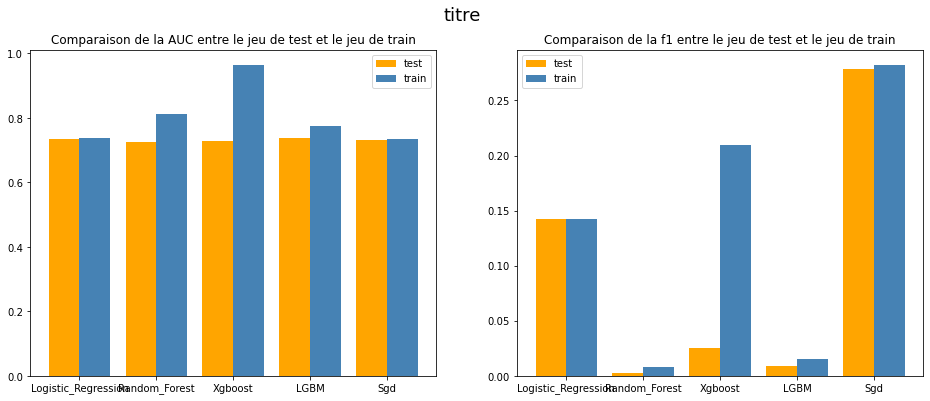

In [45]:
plot_bar_metric(df00,"titre")

Logistic_Regression


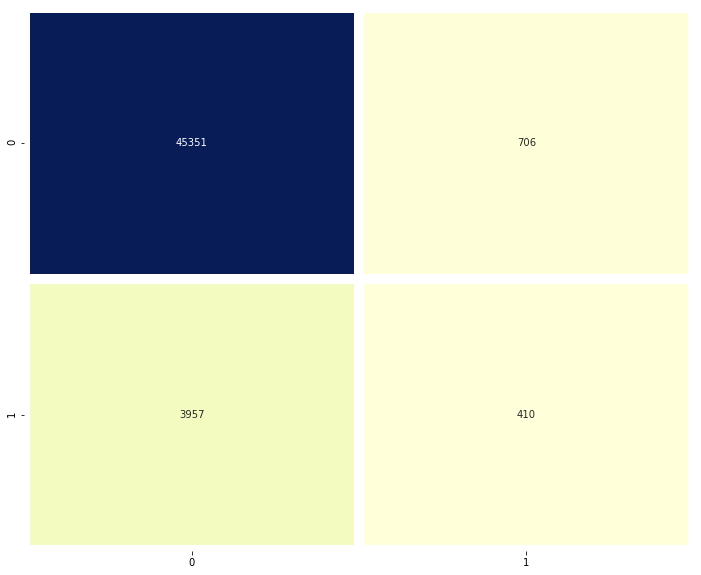

Random_Forest


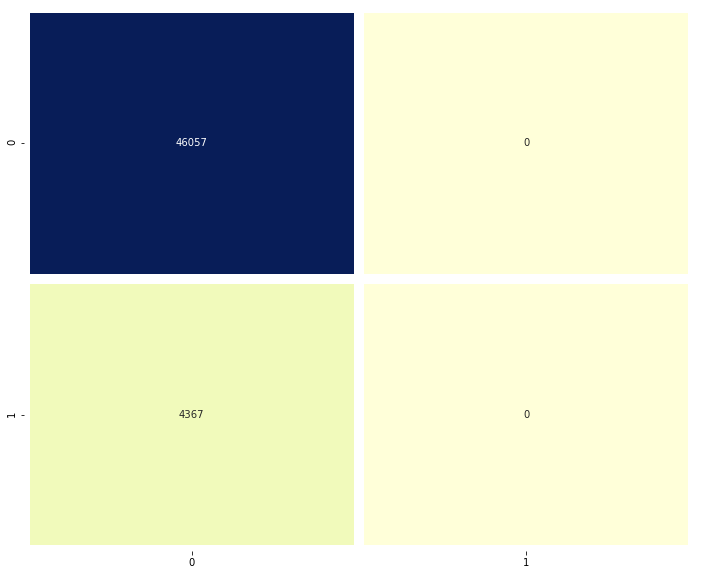

Xgboost


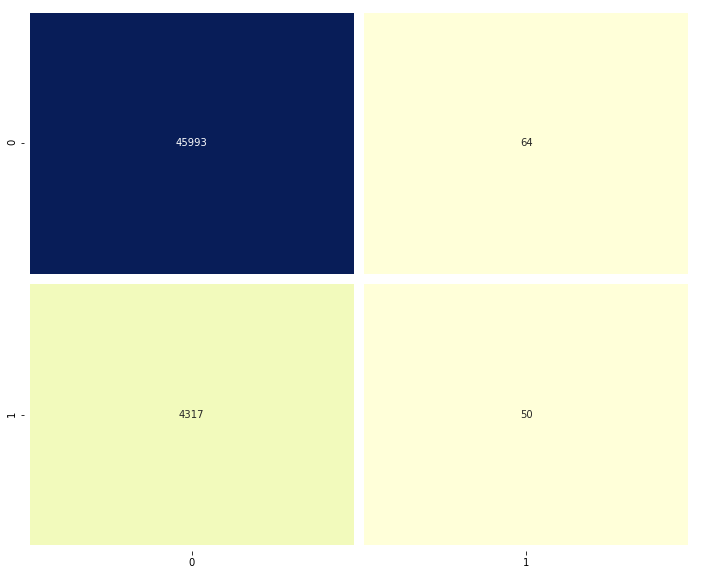

LGBM


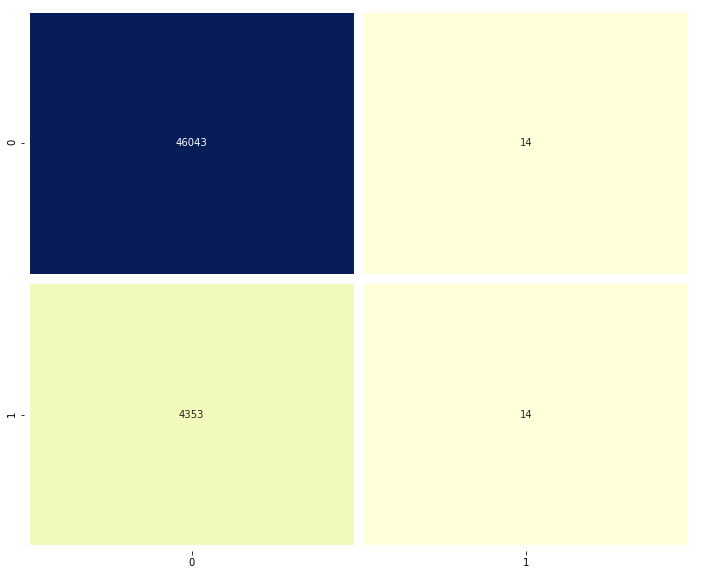

Sgd


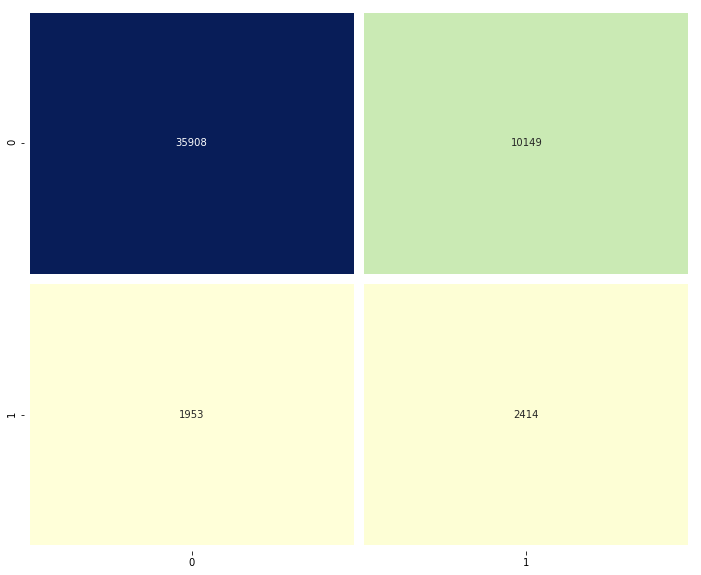

In [63]:
for n_m, model in best_estimator00.items():
    ypred = model.predict(X_test)
    print(n_m)
    plt.figure(figsize=(12,10))
    sns.heatmap(confusion_matrix(y_test, ypred),annot=True,fmt='.5g',cbar=False,linewidths=10, cmap="YlGnBu")
    plt.show()

In [66]:
best_params00["Sgd"]

{'smote__sampling_strategy': 0.7000000000000002,
 'smote__k_neighbors': 30,
 'kbst__k': 65,
 'classifier__max_iter': 1000}